# Predictive Survival Analysis

This type of analytics answer the question "what will happened?"

# Survival Regression


Whenever we have additional variables next to duration & event, we can use survival regression. 

## Taxonomy of Statistical Methods 


![image](_asset/taxonomy-predictive.jpg)

*Taxonomy of predictive statistical survival methods.  ML for Survival Analysis: A Survey [2018]*

Among the many methods available, Cox proportional hazard (CPH) and accelerated failure models are popular with many implementation. These methods model hazard rate $h(t, x)$, as a function of time $t$ and covariate $x$

## CPH Model
Traditional models, e.g., line linear regression, can not be used due to censoring. CPH model is based on the idea that log of the hazard is a linear function of covariates

$$
\log \left [ \frac{h(t, x)}{h_0(t)} \right ] = \beta ^{\top} x  \, \Longrightarrow \,  h(t,x) = h_0(t) \, e^{\beta ^{\top} x}  
$$

where $x$ and $\beta$ are variable and regression coefficient vectors, respectively, and $h_0(t)$ is a base-line hazard function (semi-parametric & non-negative). 

Attention: The only time-varying component in CPH model is the base-line hazard $h_0(t)$, where individual covariates would only scale this function with the time-invariant factor $e^{\beta ^{\top} x}$ 

### PH Assumption

The Proportional Hazards assumption means that the hazard ratio of two sample is constant over time (time-invariant), 

$$
 \frac{h(t, x_1)}{h(t, x_2)} = \frac{h_0(t) \, e^{\beta ^{\top} x_1}}{h_0(t) \, e^{\beta ^{\top} x_2} } = e^{\beta ^{\top} (x_1 - x_2)} 
$$

In below figure, we see the survival function given different values of the covariate $x$ 

- All the survival curves are a scaling of the base-line hazard
- Given PH assumption, any two arbitrary survival curve has a time-invariant hazard rate 

![image](_asset/proportional-hazard-assumption.jpg)

*Survival function vs time, given different covariates. Courtesy of ifelines.readthedocs.io*



Crossing of the survival/hazard curves for two or more categories of a predictor of interest, signal that the PH assumption is not met. However, it is possible that the functions do not cross and the PH assumption is not met. Thus, other approaches are needed to check PH assumption than curves crossing in a graph.

```{note}
Checking cox proportional hazard assumption is not important for predictive analytics, while 
the situation is different in prescriptive analytics. 

- In prediction the objective is to maximize an accuracy metric, and not to learn about how individual feature contribute to the model making that prediction.

- In prescriptive analytics, the focus is on inference & correlation and to understand the influence of individual variables on the survival duration & event.
```

### Dataset

The data is related to 432 convicts who were released from Maryland state prisons in the 1970s and who were followed up for one year after release. Half the released convicts were assigned at random to an experimental treatment in which they were given financial aid; half did not receive aid {cite}`rossi2013money`. Below, there is a sneak peek at the features distributions of this experimental dataset.

- fin: whether the inmate received financial aid after release.
- prio: The number of convictions an inmate had prior to incarceration.
- mar: whether the inmate was married at the time of release or not
- wexp: whether the inmate had full-time work experience before incarceration or not.
- paro: whether the inmate was released on parole or not.

[Further info](https://search.r-project.org/CRAN/refmans/penPHcure/html/cpRossi.html)

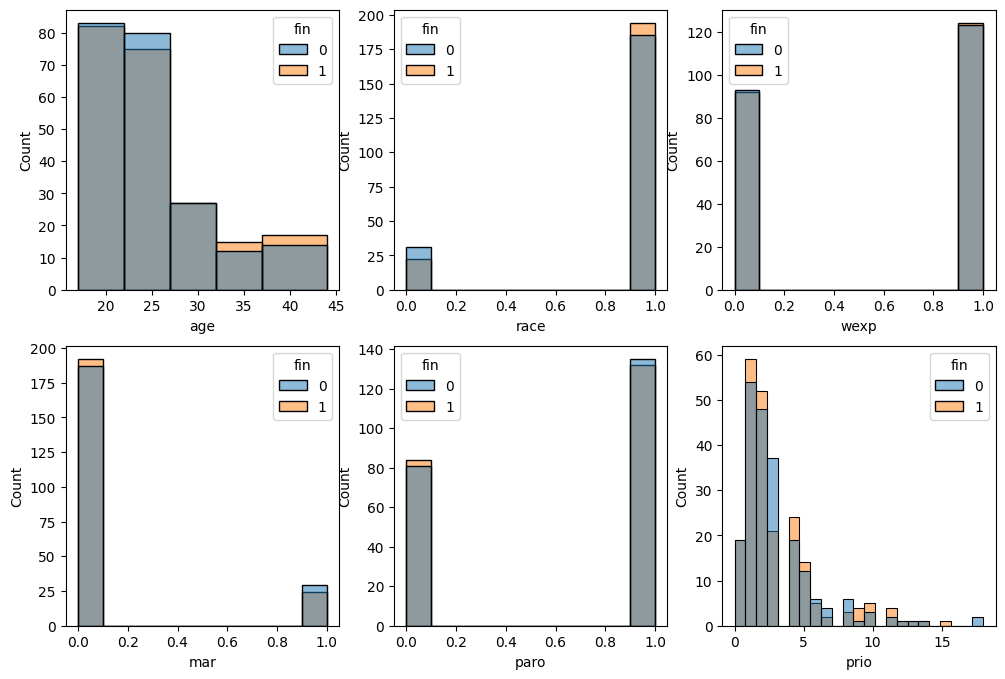

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.datasets import load_rossi

df = load_rossi()

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
cols = df.columns.drop(['fin','week', 'arrest'])
axes = ax.ravel() 
for id, col in enumerate(cols):
    _ax = axes[id] 
    bins = [17, 22, 27, 32, 37, 44] if col == 'age' else 'auto'
    sns.histplot(data=df, x=col, hue='fin', alpha=0.5, bins=bins, ax=_ax)
    _ax.set_xlabel(col)

### Fitting CPH

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df, duration_col='week', event_col='arrest')

cph.print_summary()  

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-04-11 10:31:28 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

```{note}
For those interested in R formulas can use the argument `fromula`  to handel the right-hand-side of the linear model. In the above case, `fromula='fin + age + race + wexp + mar + paro + prio' `
```

## Interpretation

### Metrics
- partial log-likelihood is the cost function. Iteratively find $\hat \beta$ via maximum partial likelihood estimator (MPLE) with the numerical Newton-Raphson )

- breslow estimator is used to estimate $\hat H_0$. Then the baseline survival function can be calculated as $S_0(t) = e^{-H_0(t)}$

- Concordance will be elaborated in evaluation section 

### Scores

Let's consider `fin` variable (whether subject provided with financial aid after release), a one unit increase in `fin` means the base-line hazard will decrease by $e^{-0.37} = 0.69$, why?

$$
 \frac{h(t | fin = 1)}{h(t | fin= 0)} = e^{\beta_{fin} (1- 0)} = e^{\beta_{fin}} = e^{-0.37} 
$$

Since the hazard ratio (vs base-line) is $0.69$ (< 1), we can argue financial aid reduces the risk of subjects getting re-arrested by 31%.

Along the same line of reasoning, whether the subject had prior arrest or not, i.e., `prio`, increase the risk of subjects getting re-arrested by 9%, with hazard ratio of $e^{0.09} = 1.09$


# Model Evaluation 

Due to censoring metrics like Root Mean Square (RMS) and $R^2$ are not relevant to survival analysis. This is because the difference between a censored value and the predicted value could be due to poor prediction or due to censoring. Specialized evaluation metrics for survival analysis are 

- c-index, 
- Brier score, 
- Mean Absolute Error (MAE),

### Concordance Index [C-index]

Definition of C-index: 

$$ C-index := \frac{\#  concordant \,\,\, pairs}{\# comparable \,\,\,  pairs} $$

- Concordant pair: the pair $(i, j)$ is concordant if $t_i > t_j$ and $\hat t_i > \hat t_j$ where $t$ is the observed time and $\hat t$ is the estimated survival time
- Comparable pairs: 

![imae](_asset/c-index.jpg)


# Model Prediction

## Data

Let's define an synthetic data to represent a low-risk and a high-risk subject.

In [70]:
import pandas as pd
 
X = pd.DataFrame({'fin':[1, 0], 'age': [45, 35], 'race': [0, 1], 'wexp': [1, 0], 'mar': [1, 0], 'paro': [1, 0], 'prio': [0, 10]})

## Survival & Cumulative Hazard functions

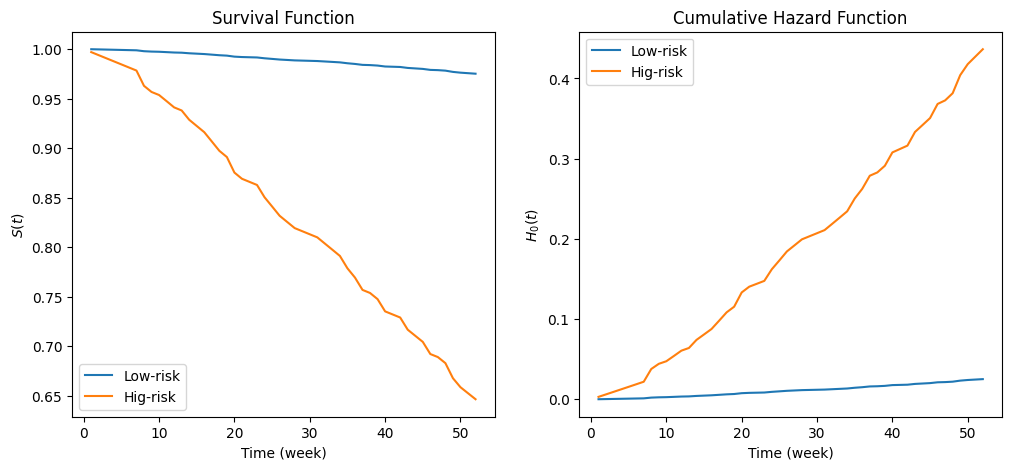

In [125]:
import matplotlib.pyplot as plt
import numpy as np 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cph.predict_survival_function(X).rename(columns={0: 'Low-risk', 1: 'Hig-risk'}).plot(ax=axs[0])
cph.predict_cumulative_hazard(X).rename(columns={0: 'Low-risk', 1: 'Hig-risk'}).plot(ax=axs[1])

axs[0].set_ylabel('$S(t)$')
axs[0].set_title('Survival Function')
axs[1].set_ylabel('$H_0(t)$')
axs[1].set_title('Cumulative Hazard Function')

for ax in axs: 
    ax.set_xlabel('Time (week)')


## Percentile

Returns the median lifetimes for the individuals p = 0.5, by default. If the survival curve of an individual does not cross 0.5, then the result is infinity

In [96]:
for p in [0.5, 0.8, 0.98]:
    print(f'predicted precentile for p={p} \n', cph.predict_percentile(X, p=p))

predicted precentile for p=0.5 
 0    inf
1    inf
Name: 0.5, dtype: float64
predicted precentile for p=0.8 
 0     inf
1    33.0
Name: 0.8, dtype: float64
predicted precentile for p=0.98 
 0    45.0
1     7.0
Name: 0.98, dtype: float64


## Expectation

Definition: The area under the subject survival function

$$
E[T] = \int_0^{\infty} S(t) dt
$$

If $S(t) \not \rightarrow 0 \Rightarrow E[T]\rightarrow \infty $. Then the returned values are meaningless/too large. In that  using predict_median or predict_percentile would be better.

In [48]:
cph.predict_expectation(X)


0    50.446642
1    42.545695
dtype: float64

## Prediction on censored subjects

Sometimes we are interested to predict the event time of censored subjects. In this case we need to formalize the question, what is a subject’s new survival function, given we know the subject has lived past time $\tau$,

$$ 
S(T > t | T > \tau) =  \frac{S(T > t \, \& \,   T > \tau)}{S(T > \tau)} = \frac{S(T > t)}{S(T > \tau)} = \frac{S(t)}{S(\tau)}
$$

The final relationship $S(t) / S(\tau)$ means, the original survival function is scaled by the survival function at time $\tau$. Therefore, the remaining hazard/survival of censored subjects is the remaining duration of the subject, i.e. normalized back to starting at 0. Of course, during the time period $t \in [0, \tau]$, the subject is survived with $S(t) = 1$  

In below example, we are assuming that the subjects survived from getting re-arrested until week 10. The remaining survival function from $10$ to $52$-week is shifted to start from zero

Text(0.5, 0, 'Time (week)')

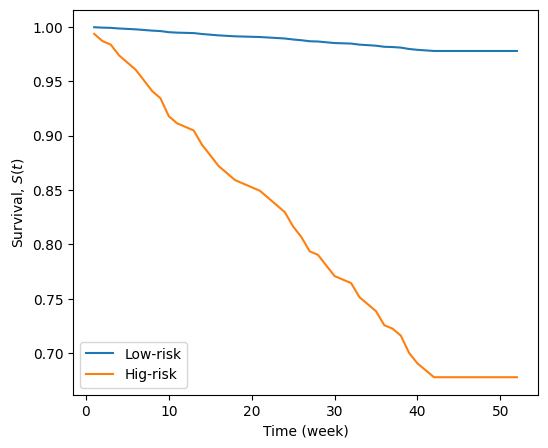

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

cph.predict_survival_function(X, conditional_after=[10, 10]).rename(columns={0: 'Low-risk', 1: 'Hig-risk'}).plot(ax=ax)

ax.set_ylabel('Survival, $S(t)$')
ax.set_xlabel('Time (week)')


# Exercise

Repeat the above steps & sections with the German Brest Cancer data. Of course, feel free to split the data 
to train and test and explore your own ideas to fit a better model.  

- Fit a CPH model
- Interpret
- Evaluate
- Predict 


## Data

The data comes from German Breast Cancer Study Group, where in Randomized 2 x 2 clinical trial was aiming to evaluate hormonal treatment and the duration of chemotherapy in node-positive breast cancer patients {cite}`schumacher1994randomized`

- horTh: hormonal therapy, a factor at two levels no and yes.


- age: of the patients in years.
- menostat: 0 menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- tsize: tumor size (in mm).
- tgrade: tumor grade, a ordered factor at levels I < II < III.
- pnodes: number of positive nodes.
- progrec: progesterone receptor (in fmol).
- estrec: estrogen receptor (in fmol).
- time: recurrence free survival time (in days).
- cens: censoring indicator (0- censored, 1- event).

*Recurrence Free Survival: defined as the length of time from the end of primary treatment (Surgery/chemotherapy) until there is evidence of cancer recurrence or until the death of the patient.*

In [8]:
from lifelines.datasets import load_gbsg2
df = load_gbsg2()
df

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1
...,...,...,...,...,...,...,...,...,...,...
681,no,49,Pre,30,III,3,1,84,721,0
682,yes,53,Post,25,III,17,0,0,186,0
683,no,51,Pre,25,III,5,43,0,769,1
684,no,52,Post,23,II,3,15,34,727,1


# Further topics

## Taxonomy of ML methods

![image.png](_asset/taxonomy-ml.jpg)

```{seealso} 
The idea behind some of the machine learning models in the above toxonomy are presented in [Survival Analysis: a deep dive | PyData Amsterdam 2023](https://www.youtube.com/watch?v=I33h5-GmHSM)
```

## Accounting for time-varying covariate 

Accounting for time-varying covariate can be done by aggregation for low frequency variables and feature extraction for high-frequency variables.  

- Low-frequency time-varying variables, i.e., age, can be aggregated to mean or other statistical functions
- High-frequency time-varying variables, i.e., stock price fluctuation, can undergo feature extraction algorithms like catch22 {cite}`lubba2019catch22`.  